In [26]:
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
back_test_df= pd.read_csv('./backtest_30/back_test_0925_30.csv')
kodex_df = pd.read_csv('./backtest_20/kodex_return.csv')

In [28]:
# 백테스트 날짜와 함께 결과 DataFrame 생성
def backtest(y_pred, y_test, dates) :
    results_df = pd.DataFrame({
        'date': dates[-len(y_pred):],  # 테스트 세트와 동일한 길이의 날짜 데이터
        'y_test': y_test.values,  # y_test를 1차원 배열로 변환
        'y_pred': y_pred  # y_pred는 이미 1차원 배열임
    })
    results_df.set_index('date', inplace=True)
    backtest_open = pd.read_csv('./backtest/kodex_open.csv')
    backtest_open['date'] = pd.to_datetime(backtest_open['date'],format= "%Y%m%d")
    backtest_open.set_index('date', inplace=True)
    back_test_df = pd.merge(results_df,backtest_open, right_index=True,left_index=True, how='inner')
    return back_test_df
    

In [29]:
def backtest_concat(back_test_df, kodex_df) :
    # 'date' 컬럼의 데이터 형식을 일치시키기 위해 kodex 데이터의 'date'를 문자열로 변환
    kodex_df['date'] = pd.to_datetime(kodex_df['date'].astype(str), format='%Y%m%d')

    # back_test 데이터의 'date'도 datetime 객체로 변환
    back_test_df['date'] = pd.to_datetime(back_test_df['date'])

    # 두 데이터 프레임을 'date'를 기준으로 병합
    merged_backtest = pd.merge(back_test_df, kodex_df, on='date', how='inner')

    # 결과 확인
    return merged_backtest

merged_backtest = backtest_concat(back_test_df, kodex_df)

In [30]:
def backtest_strategy_with_commission_filter(df, commission=0.015):
    """
    Execute a backtesting strategy based on predicted and actual open prices, considering commission.

    Parameters:
    df (DataFrame): The dataframe with columns 'open', 'y_pred', and 'y_test'.
    commission (float): The commission rate for the transactions.

    Returns:
    DataFrame: The dataframe with the backtesting results including cumulative profit and total real profit.
    """
    # Calculate the profit/loss for both long and short positions
    df['profit_long'] = (df['y_pred'] - df['open'] * (1 + commission)) / df['open']
    df['profit_short'] = (df['open'] * (1 - commission) - df['y_pred']) / df['open']
    
    # Apply the real profit considering the commission and only execute if the expected profit is greater than commission
    df['real_profit_long'] = df.apply(
        lambda row: (row['y_test'] - row['open'] * (1 + commission)) / row['open'] if row['profit_long'] > commission else 0,
        axis=1
    )
    df['real_profit_short'] = df.apply(
        lambda row: (row['open'] * (1 - commission) - row['y_test']) / row['open'] if row['profit_short'] > commission else 0,
        axis=1
    )
    
    # Apply the real profit considering the actual transaction and the commission filter
    df['real_profit'] = df.apply(
        lambda row: row['real_profit_long'] if row['profit_long'] > commission else (row['real_profit_short'] if row['profit_short'] > commission else 0),
        axis=1
    )
    
    # Calculate the cumulative profit
    df['cumulative_profit'] = (1 + df['real_profit']).cumprod() - 1
    
    # Add a column for the total real profit
    df['total_real_profit'] = df['real_profit'].cumsum()
    # 누적 수익률 계산 (1 + r_t).cumprod()를 사용하여 각 시점의 누적 곱을 계산

    df['kodex_cumulative_return'] = (1 + df['kodex_return'].fillna(0)).cumprod() - 1


    
    # Return the relevant columns
    return df[['date', 'open', 'y_pred', 'y_test', 'profit_long', 'profit_short', 'real_profit_long', 'real_profit_short', 'real_profit', 'cumulative_profit', 'total_real_profit','kodex_cumulative_return']]

# Run the backtest strategy function with commission filter on the loaded dataframe
backtest_results = backtest_strategy_with_commission_filter(merged_backtest)

# Display the first few rows of the backtesting results with commission filter
backtest_results.head(20)

## 백테스트 결과 저장
# backtest_results.to_csv('./backtest_result/lr_0910_30.csv')

,date,open,y_pred,y_test,profit_long,profit_short,real_profit_long,real_profit_short,real_profit,cumulative_profit,total_real_profit,kodex_cumulative_return
0,2022-04-18,34636.0,35035.692584,34911.0,-0.003460,-0.026540,0.0,0.0,0.0,0.0,0.0,0.008121
1,2022-04-19,34911.0,34343.646309,34424.0,-0.031251,0.001251,0.0,0.0,0.0,0.0,0.0,0.016125
2,2022-04-20,34983.0,34614.337748,34867.0,-0.025538,-0.004462,0.0,0.0,0.0,0.0,0.0,0.018220
3,2022-04-21,34713.0,34897.182137,34660.0,-0.009694,-0.020306,0.0,0.0,0.0,0.0,0.0,0.010362
4,2022-04-22,34266.0,34993.352972,35098.0,0.006227,-0.036227,0.0,0.0,0.0,0.0,0.0,-0.002649
5,2022-04-25,34227.0,34713.358612,34578.0,-0.000790,-0.029210,0.0,0.0,0.0,0.0,0.0,-0.003784
6,2022-04-26,33770.0,34255.997286,34246.0,-0.000609,-0.029391,0.0,0.0,0.0,0.0,0.0,-0.017085
7,2022-04-27,34033.0,34237.629899,34242.0,-0.008987,-0.021013,0.0,0.0,0.0,0.0,0.0,-0.009430
8,2022-04-28,34189.0,33746.824050,33582.0,-0.027933,-0.002067,0.0,0.0,0.0,0.0,0.0,-0.004890
9,2022-04-29,34277.0,34004.929643,33842.0,-0.022937,-0.007063,0.0,0.0,0.0,0.0,0.0,-0.002328


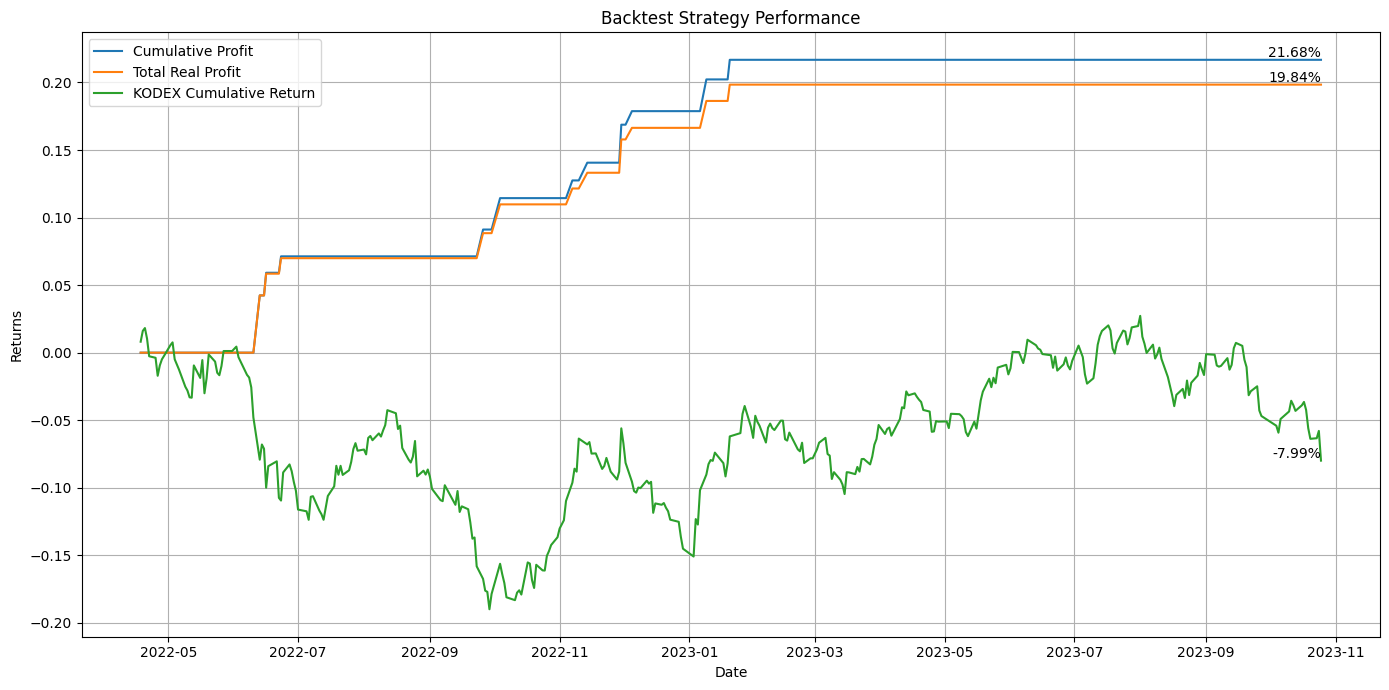

In [31]:
import matplotlib.pyplot as plt

# 그래프에 'cumulative_profit', 'total_real_profit', 'kodex_cumulative_return'의 마지막 값을 표시합니다.
plt.figure(figsize=(14, 7))

# 'cumulative_profit' 컬럼을 선으로 시각화하고 마지막 값을 표시합니다.
if 'cumulative_profit' in backtest_results.columns:
    plt.plot(backtest_results['date'], backtest_results['cumulative_profit'], label='Cumulative Profit')
    last_value = backtest_results['cumulative_profit'].iloc[-1]
    plt.text(backtest_results['date'].iloc[-1], last_value, f'{last_value:.2%}', va='bottom', ha='right')

# 'total_real_profit' 컬럼을 선으로 시각화하고 마지막 값을 표시합니다.
if 'total_real_profit' in backtest_results.columns:
    plt.plot(backtest_results['date'], backtest_results['total_real_profit'], label='Total Real Profit')
    last_value = backtest_results['total_real_profit'].iloc[-1]
    plt.text(backtest_results['date'].iloc[-1], last_value, f'{last_value:.2%}', va='bottom', ha='right')

# 'kodex_cumulative_return' 컬럼을 선으로 시각화하고 마지막 값을 표시합니다.
if 'kodex_cumulative_return' in backtest_results.columns:
    plt.plot(backtest_results['date'], backtest_results['kodex_cumulative_return'], label='KODEX Cumulative Return')
    last_value = backtest_results['kodex_cumulative_return'].iloc[-1]
    plt.text(backtest_results['date'].iloc[-1], last_value, f'{last_value:.2%}', va='bottom', ha='right')

# 제목 및 라벨 추가
plt.title('Backtest Strategy Performance')
plt.xlabel('Date')
plt.ylabel('Returns')

# 범례 표시
plt.legend()

# 레이아웃 개선 및 그리드 추가
plt.tight_layout()
plt.grid(True)
plt.show()
